# A2. Models of complex networks Assignment

Galata Aglaia-Elli & Kharitonova Ksenia


# Imports

In [109]:
import random
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import numpy as np
from random import choices
import seaborn as sns
import os
from scipy.stats import binom, linregress

sns.set()
np.random.seed(0)
sns.set(style="whitegrid")
sns.set_palette("Set3", 10)

# Erdos Renyi G(n, m)

In [2]:
def erdos_renyi_e(n, m):
    '''Creates random Erdos-Renyi graph from n nodes and k edges.
    '''
    G = nx.Graph()
    total_nodes = list(range(n))
    G.add_nodes_from(total_nodes)
    max_edges = n * (n - 1) / 2
    if m == 0:
        return G
    elif m == max_edges:
        G = complete_graph(n, using=G)
        return G
    else:
        total_edges = list(combinations(range(n), 2))
        random_edges = random.sample(total_edges, m)
        G.add_edges_from(random_edges)
    return G

# Erdos Renyi G(n, p)

In [3]:
def erdos_renyi_p(n, p):
    '''Creates random Erdos-Renyi graph from n nodes and probability p of forming the edge.
    '''
    G = nx.Graph()
    total_nodes = list(range(n))
    G.add_nodes_from(total_nodes)
    max_edges = n * (n - 1) / 2
    if p == 0:
        return G
    elif p == 1:
        G = complete_graph(n, using=G)
        return G
    else:
        total_edges = list(combinations(range(n), 2))
        m = int(round(p*max_edges,0))
        random_edges = random.sample(total_edges, m)
        G.add_edges_from(random_edges)
    return G

# Barabasi & Albert

In [4]:
def barabasi_albert(n, m):
    '''Creates Barabasi & alber graph from m average degree of the resulting network.
    '''

    G = nx.Graph()
    # Create a complete graph with a small number of nodes
    if n < m:
        G = nx.complete_graph(n, create_using=G)
        return G
    else:
        G = nx.complete_graph(m, create_using=G)

    for i in range(m, n):
        n_nodes = G.number_of_nodes()
        population = list(range(n_nodes))
        sum_degree = sum([G.degree[node] for node in G.nodes])
        if sum_degree != 0:
            weights = [G.degree[node]/sum_degree for node in G.nodes]
            edges = choices(population, weights, k=m)
            G.add_node(i)
            z = list(zip([i]*m, edges))
            G.add_edges_from(z)
        else:
            G.add_node(i)
            G.add_edges_from([(0, i)])
    #

    # nx.draw_networkx(G, with_labels=False, node_size=12)
    # plt.show()
    return G

def barabasi_albert_theoretical():
    return None

# Plot Degree Distributions

In [5]:

def change_width(ax, new_value):
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff*0.9)


def get_pdf(graph):
    n_nodes = graph.number_of_nodes()
    deg = list(nx.degree(graph))
    node_indexes, node_degrees = zip(*deg)
    n_bins = len(set(node_degrees))
    n_bins = 1 + int(np.ceil(3.5 * np.log(n_bins)))

    minimum = np.log(np.min(node_degrees))
    maximum = np.log(np.max(node_degrees))

    log_node_degrees = np.log(node_degrees)
    interval_step = (maximum - minimum)/ n_bins

    probabilities = []
    x = []
    for i in np.linspace(minimum, maximum, n_bins):
        mean_bin = (i + interval_step)/2
        mean_bin = np.round(mean_bin, 3)
        x.append(mean_bin)
        count = len(list(x for x in log_node_degrees if i <= x <= i+interval_step - 0.00001))
        probabilities.append(count/n_nodes)

    return pd.DataFrame({'probabilities': probabilities, 'log degrees': x})
    #return pd.DataFrame({'probabilities': probabilities, 'degrees': x})


def degree_distribution(exp_graph, theory_graph):
    experiment = get_pdf(exp_graph)
    theory = get_pdf(theory_graph)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    change_width(axes[0], 1.0)
    change_width(axes[1], 1.0)
    sns.barplot(x="log degrees", y="probabilities", data=experiment, ax=axes[0]).set_title('Experiment')
    sns.barplot(x="log degrees", y="probabilities", data=theory, ax=axes[1]).set_title('Theoretical')


    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=40, ha="center", fontsize=8)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=40, ha="center", fontsize=8)

    fig.tight_layout()
    plt.show()


In [6]:
G = erdos_renyi_p(1000, 0.2)

In [7]:
from scipy.stats import binom

In [8]:
n_nodes = G.number_of_nodes()
deg = list(nx.degree(G))
node_indexes, node_degrees = zip(*deg)

degrees_th = list(set(node_degrees))
p_th = [binom.pmf(k, 999, 0.2) for k in degrees_th]

Text(0.5, 1.0, 'Degree distribution of Erdos-Renyi graph with 1000 nodes and p=0.2')

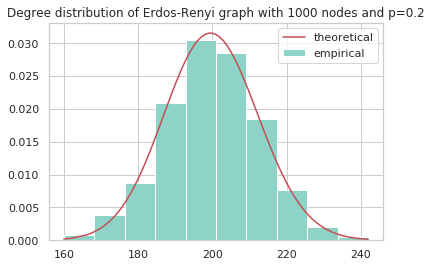

In [9]:
plt.hist(node_degrees, density=True, label='empirical')
plt.plot(degrees_th, p_th, c='r', label='theoretical')
plt.legend()
plt.title('Degree distribution of Erdos-Renyi graph with 1000 nodes and p=0.2')

In [174]:
G2 = barabasi_albert(1000,5)

In [175]:
def estimate_exponent(G):
    n_nodes = G.number_of_nodes()
    deg = list(nx.degree(G))
    node_indexes, node_degrees = zip(*deg)
    log_degrees = np.array([np.log(k) for k in node_degrees])
    bins = np.linspace(np.log(min(node_degrees)), np.log(max(node_degrees)+1), 11)
    binned_values = []
    for i in range(10):
        binned_values.append(len(log_degrees[(log_degrees>=bins[i]) & (log_degrees<bins[i+1])]))
    prob = np.array(binned_values)/np.sum(binned_values)
    slope, intercept, r_value, p_value, std_err = linregress(bins[:10],np.log(prob))
    return -slope+1

In [176]:
estimate_exponent(G2)

2.6206863034856687

In [177]:
estimate_exponent(barabasi_albert(2000,3))

2.591915822817856

In [178]:
estimate_exponent(barabasi_albert(2000,5))

2.6460335884040163

In [179]:
estimate_exponent(barabasi_albert(1000,2))

1.8267730161626274

In [180]:
def plot_ba_graph(G, n, k, C):
    n_nodes = G.number_of_nodes()
    deg = list(nx.degree(G))
    node_indexes, node_degrees = zip(*deg)
    plt.hist(node_degrees, 10 ** np.linspace(np.log10(min(node_degrees)), np.log10(max(node_degrees)), 20), log=True, density=True, label='empirical')
    plt.plot([10**np.log10(k) for k in list(set(node_degrees))],[C*k**(-3) for k in [10**np.log10(k) for k in list(set(node_degrees))]], c='r', label='theoretical')
    plt.gca().set_xscale("log")
    plt.legend()
    plt.title(f'Power-law degree distribution of PA graph with {n} nodes and k={k}')
    plt.show()

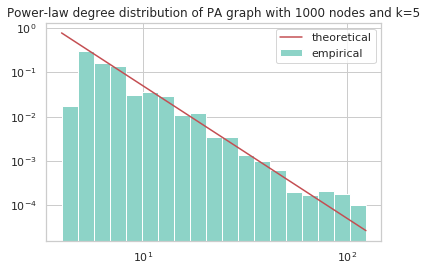

In [181]:
plot_ba_graph(G2, 1000, 5, 50)

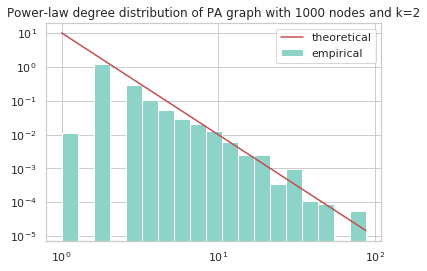

In [183]:
plot_ba_graph(barabasi_albert(1000,2),1000,2,10)